The material in this notebook follows Andrej Karpathy's nanoGPT tutorial (https://www.youtube.com/watch?v=kCc8FmEb1nY)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [22]:
#Loading the TinyShakespeare Dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-01-22 05:41:00--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-01-22 05:41:00 (22.1 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [23]:
with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [24]:
print(f'The dataset contains {len(text)} characters')

The dataset contains 1115394 characters


In [25]:
print(type(text)) #this dataset is just a big string (not a list of strings, we haven't used split or anything)
print(text[:1000])

<class 'str'>
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst 

In [26]:
# extract the unique characters/symbols/atoms that build the dataset
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [27]:
# TOKENIZER
# map characters to integers and vice versa
# this corresponds to a character level tokenizer
# state of the art methods tend to use subword level tokenizers
#
# note that although simple, character level tokenizers tend to produce very long sequences compared to other tokenizers.

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s] # converts string (list of characters) to integers
decode = lambda l: ''.join([itos[i] for i in l]) #converts list of integers to a single string (list of characters)

print(encode('hello there'))
print(decode(encode('hello there')))

[46, 43, 50, 50, 53, 1, 58, 46, 43, 56, 43]
hello there


torch.Size([1115394]) torch.int64


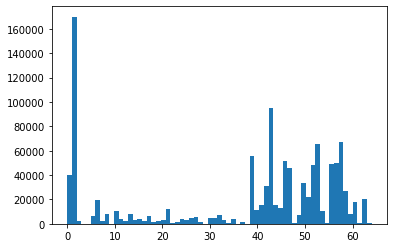

In [28]:
# encoding the dataset and storing as a tensor

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)

plt.hist(data, vocab_size)
plt.show()

In [29]:
print(f'The most occuring character is: "{itos[1]}"')

The most occuring character is: " "


In [30]:
## Training and validation split of the data

n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In most applications, the training dataset is massive to be fed into the transformer all at once. Instead, training is performed by randomly sampling blocks or subsequences from the training set of a specified size, which is refered to here as a $\texttt{block_size}$ or a $\texttt{context_length}$. These blocks are ordered and contain multiple pieces of information. For example, consider  $\texttt{block_size} = N$, e.g., 

$[1,...,N]$

As we are interested in predicting next tokens, we can create the following list of training examples from that single block with the format $\texttt{target}$ | $\texttt{input}$:

$1|$

$2|1$

$3|2,1$

...

$N | N-1,....,1$

Hence the training using contexts of size $1$ all the way up to $\texttt{block_size}$ 

In [31]:
# here is an example of the above

block_size = 8 # context length
print(f'The first training block is {train_data[:block_size+1]}')
print(f'From this block, we can construct the following prediction cases.')
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
  context = x[:t+1]
  target = y[t]
  print(f'When the input is {context}, the target is {target}.')

The first training block is tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])
From this block, we can construct the following prediction cases.
When the input is tensor([18]), the target is 47.
When the input is tensor([18, 47]), the target is 56.
When the input is tensor([18, 47, 56]), the target is 57.
When the input is tensor([18, 47, 56, 57]), the target is 58.
When the input is tensor([18, 47, 56, 57, 58]), the target is 1.
When the input is tensor([18, 47, 56, 57, 58,  1]), the target is 15.
When the input is tensor([18, 47, 56, 57, 58,  1, 15]), the target is 47.
When the input is tensor([18, 47, 56, 57, 58,  1, 15, 47]), the target is 58.


Recall the analogy with joint probabilities. For a sequence $\{t_1,...,t_N\}$, the joint probability has the following factorization:

$p(t_1,...,t_N) = p(t_1) p(t_2|t_1) p(t_3| t_2,t_1) ... p(t_{N} | t_{N-1},...,t_1)$ 

Transformers are not trained on individual blocks, but rather minibatches of multiple blocks. Hence, the $\texttt{batch_size}$ is also an important hyperparameter. The primary reason for doing this is for efficiency.  

In [71]:
#Some default hyperparameters, which we will change throughout
batch_size = 32
block_size = 8
max_iters = 3000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

In [72]:
torch.manual_seed(1337)
batch_size = 4 # how many independent blocks/sequences will we process in parallel?
block_size = 8 # what is the max context length for predictions?

def get_batch(opt):
  data = train_data if opt == 'train' else val_data
  #select n random starting indices for a sequence of size block_size, where n = batch_size
  ix = torch.randint(len(data) - block_size, (batch_size,)) 
  x = torch.stack([data[i:i+block_size] for i in ix]) #create each block at each starting location in ix
  y = torch.stack([data[i+1:i+block_size+1] for i in ix]) #create targets for each block in the batch
  x,y = x.to(device), y.to(device)
  return x, y 

#next, we sample a batch from the training data set
xb, yb = get_batch('train') 

print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

#below we unpack all of the examples stored in each block in the batch
for b in range(batch_size): #b = batch
  for t in range(block_size): #t = time
    context = xb[b,:t+1]
    target = yb[b,t]
    print(f'When input is {context.tolist()}, the target is: {target}')


inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
When input is [24], the target is: 43
When input is [24, 43], the target is: 58
When input is [24, 43, 58], the target is: 5
When input is [24, 43, 58, 5], the target is: 57
When input is [24, 43, 58, 5, 57], the target is: 1
When input is [24, 43, 58, 5, 57, 1], the target is: 46
When input is [24, 43, 58, 5, 57, 1, 46], the target is: 43
When input is [24, 43, 58, 5, 57, 1, 46, 43], the target is: 39
When input is [44], the target is: 53
When input is [44, 53], the target is: 56
When input is [44, 53, 56], the target is: 1
When input is [44, 53, 56, 1], the target is: 58
When input is [44, 53,

In [73]:
# Helper functions

@torch.no_grad()
def estimate_loss(model):
  out = {}
  model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split)
      logits, loss = model(X,Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

In order to build up to a Transformer network, we will first recall the Bigram language model.

In [33]:
class BigramLanguageModel(nn.Module):

  def __init__(self, vocab_size):
    super().__init__()
    # Each token directly reads off the logits for the next token from a lookup table.
    # This lookup table is basically a transition probability matrix, where the probabilities are replaced by logits.
    # Hence, entry (i,j) of the table corresponds to the logit associated with transitioning from the current token i the next token j.
    # Thus the i-th row contains the logits (probability distribution over the vocabulary) for the next token.

    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) #(C,C)

  def forward(self, idx, targets=None):
    # Let B = batch_size, T = time, C = channels = vocab_size 
    # idx and targets are both integer tensors of dimension (B,T) 
    logits = self.token_embedding_table(idx) #(B,T,C)
    # logits(b,t,:) contains the logits for predicting the next token given that we are currently at token t in batch b.
    # these logits correspond to a probability distribution over the vocabulary.
    
    # we need to reshape things to work with F.cross_entropy
    
    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T) 
      loss = F.cross_entropy(logits, targets) #(B,T)      

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is of dim (B,T) whose (b,t)th entry corresponds to the vocabulary index in batch b at time t
    # max_new_tokens is how many new tokens to sample

    ## Note: In this simple bigram model, we only need to keep track of the latest indices and not the entire history.
    ##       In the following code, we actually keep track of all of the indices in 'idx' and continually append to it.
    ##       This is because we will need this capability in subsequent models that have more context.
    for _ in range(max_new_tokens):
      # make the predictions (probability distributions over next entries)
      logits, loss = self(idx) # logits is (B,T,C), loss is (B*T)
      # focus on the last time step because that is the only context needed for bigram predictions
      logits = logits[:,-1,:] # (B,C)
      # convert logits to probs
      probs = F.softmax(logits, dim=-1) #(B,C)
      # sample
      idx_next = torch.multinomial(probs, num_samples=1) #(B,1)
      # appending new sampled indices to our current set
      idx = torch.cat((idx, idx_next), dim=1) #(B,T+1)
    return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb,yb)

In [34]:
loss

tensor(5.0364, grad_fn=<NllLossBackward0>)

In [35]:
preds = m.generate(xb, 20)

decode(preds[0].tolist())

"Let's heXJamq!iui$HDXDFZuBSu"

In [36]:
idx = torch.zeros((1,1), dtype=torch.long)
print( decode( m.generate(idx, max_new_tokens=500)[0].tolist() ))


klcPU cL'DpdLCafBheHd:.?nA!LgjgL&jcM-sZW!HFsWt'rv.x;z&hPyd'XHOxnAcj.erRjcLxxVFSrOpW.oeGJ Ai$yi&!mRfeopx,f.e..iBgxVrl-VThV?W?qF;roi!NxbR;zyDlfd&DH'X;PgqTOMcL
HvR;tg;tEkFST$Cil;AkkEptkGClcJ NoPTeZLPX.B-aft'ZEl'rJfEDm&UZ
RENz-sr rR:Z'IU,V-PWgQlYc-Gq$$yg;TvDY?ACacM.NkPHGpGJakq!3M!HOhbvD.llo;r;lpXezY;.LOMm!q$AYf$XyG$xWSufzLpMafJsqGbbRRMqNZtSbbKIIUCqVHyVeD
PWyYswQKBHvb.CoPUCQA& :OTT fzrauAYI!3SU hP xWt'vkAHpniwCy,XyHWvXv.YJsixViwxaxysgOy,
ipQwl ItwYD
;erIZxaX,HAzloSmjtI?YMieH3Z jaNs
aVCyddL
N,OpZty;aK


Obviously, this purely random model spits out gibberish. Now we will train this model on the tinyShakespeare dataset.

In [37]:
# define some hyperparameters
batch_size = 32
block_size = 8
max_iters = 3000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

In [38]:
# PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [39]:
for steps in range(10000):
  #minibatch
  xb, yb = get_batch('train')

  #loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

2.5369927883148193


In [40]:
idx = torch.zeros((1,1), dtype=torch.long)
print( decode( m.generate(idx, max_new_tokens=500)[0].tolist() ))


3bllllleyomerer but?
The t,
Ith'dwitile w? beren to'd ff a atrts brey s

ESesenther:
Ithon f at pare ismamy an flictong m




Mameld h che IN: an y is aslo'daDut, t thethiceve fur t anowik
Wirghe f bot d at'prd
Anoper sof usy be, d s me cks bity.
CLUM3&HALou f lendys.
Y anditont avenghe m, gs gl tis y.
Wie gh-mmo hizy s on fulourachigethuiclotif qDWeZPld:
LOubour Witamul we thiech l lisowarrew bland cedanidate, fafive witherthiulsosthis thatwancaurind th'gonimake

S oveprene?
HRar oumnanoupamak 


While the model is still incomprehensible, it is considerably improved over the untrained model. At least some of the structure of has been learned. Bigram models are quite poor, but they at least provide a benchmark for comparison. We need longer contexts than just 1.

## Efficient implementations of self-attention use the following trick

Basically, to ensure causal interactions via masking. By causal, we mean that the future cannot communicate with the past. This is a form of autoregression and highlights the role of lower triangular matrices.

In [41]:
# toy example

torch.manual_seed(1337)
B,T,C = 4,8,2 #batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [42]:
# We want a causal temporal average:
#  x[b,t] = mean_{i<=t} x[b,i]
# bow = bag of words, averaging over previous words
# all notion of order is loss, so some information is loss
xbow = torch.zeros((B,T,C)) 
for b in range(B): #for each sequence in the batch
  for t in range(T): #for each time
    xprev = x[b,:t+1] #(t,C), includes the t-th entry
    xbow[b,t] = torch.mean(xprev,0) #(C) average across the previous times

In [43]:
# A more efficient formulation than for loops
# causal averaging operator
a = torch.tril(torch.ones(3,3))
a = a / a.sum(axis=1, keepdim=True)
a

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

In [44]:
wei = torch.tril(torch.ones(T,T)) #temporal averaging weights
wei = wei / wei.sum(axis=1, keepdim=True)

xbow2 = wei @ x #(T,T) @ (B,T,C) ----> (B,T,C) due to broadcasting, batch calculations done in parallel 

In [45]:
print( torch.allclose(xbow,xbow2) )
print(xbow[0], xbow2[0])

True
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]]) tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [46]:
# We can write the same averaging operator with a softmax
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

# The averaging operator 'wei' is currently a uniform average.
# In reality, we may want a more general weighted average (but still causal), where the weights can be learned.

True

## Expanding the Bigram Model
We will begin to expand the previous bigram model with seemingly redundant information. These "redundant" aspects, such as token and position embeddings become important when dealing with Transformer models.

In [48]:
# define some hyperparameters
batch_size = 32
block_size = 8
max_iters = 3000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

In [50]:
class BigramLanguageModel(nn.Module):

  def __init__(self):
    super().__init__()
    # Each token directly reads off the logits for the next token from a lookup table.
    # This lookup table is basically a transition probability matrix, where the probabilities are replaced by logits.
    # Hence, entry (i,j) of the table corresponds to the logit associated with transitioning from the current token i the next token j.
    # Thus the i-th row contains the logits (probability distribution over the vocabulary) for the next token.

    # first we embed each input token into euclidean space (rather than using a one-hot vector)
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd) #(vocab_size,n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd) #(block_size, n_embd)
    # Note the token_embedding only embeds information about the value of the token, but not its position in the context
    # Hence, we also include a position_embedding in the same space, basically as an additional learnable degree of freedom to account for the positioning within the context.
    # Importantly, the position_embedding is only used for position information and not for conveying token value. Hence it is the same within the batch.

    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    # Let B = batch_size, T = time, C = channels = vocab_size 
    # idx and targets are both integer tensors of dimension (B,T) 
    B,T = idx.shape
    tok_embd = self.token_embedding_table(idx) #(B,T,n_embd)
    pos_embd = self.position_embedding_table(torch.arange(T, device=device)) #(T, n_embd)
    x = tok_embd+pos_embd #(B,T,n_embd) + (T,n_embd) = (B,T,n_embd)
    logits = self.lm_head(x) #(B,T,vocab_size) --> corresponds to logistic model on the embedded tokens

    # logits(b,t,:) contains the logits for predicting the next token given that we are currently at token t in batch b.
    # these logits correspond to a probability distribution over the vocabulary.
    
    # we need to reshape things to work with F.cross_entropy
    
    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T) 
      loss = F.cross_entropy(logits, targets) #(B,T)      

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is of dim (B,T) whose (b,t)th entry corresponds to the vocabulary index in batch b at time t
    # max_new_tokens is how many new tokens to sample

    ## Note: In this simple bigram model, we only need to keep track of the latest indices and not the entire history.
    ##       In the following code, we actually keep track of all of the indices in 'idx' and continually append to it.
    ##       This is because we will need this capability in subsequent models that have more context.
    for _ in range(max_new_tokens):
      # make the predictions (probability distributions over next entries)
      logits, loss = self(idx) # logits is (B,T,C), loss is (B*T)
      # focus on the last time step because that is the only context needed for bigram predictions
      logits = logits[:,-1,:] # (B,C)
      # convert logits to probs
      probs = F.softmax(logits, dim=-1) #(B,C)
      # sample
      idx_next = torch.multinomial(probs, num_samples=1) #(B,1)
      # appending new sampled indices to our current set
      idx = torch.cat((idx, idx_next), dim=1) #(B,T+1)
    return idx


m = BigramLanguageModel()
logits, loss = m(xb,yb)

## The crux of attention

In [51]:
#recap
torch.manual_seed(1337)
B,T,C = 4,8,32 #batch, time, channels
x = torch.randn(B,T,C)
# x[i,:,:] is a (T,C) snapshot matrix, where the t-th row x[i,t,:] contains the C-dimensional embedding of the t-th token
# so the rows of x[i,:,:] index the time steps

tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)
out = wei @ x # causal time averages of each dimension of the embedding

With attention, we want to achieve something similar but more flexible. We still want to have information propogate in a causal way -- meaning that future tokens cannot influence the past. In constrast with the previous time averaging, however, we want this to be achieved in a data-dependent way.

To do this, we abstract the notion of weights and averaging to the notion of affinities and similarity. Such concepts have been fruitfull applied with respect to manifold learning and kernel methods on graphs. The transformer perspective is as follows.

Each token emits a query vector and a key vector in the same space. Key vectors contain information pertaining to the token's identity and query vectors contain information about what the token is looking for. We use "information" here in the loose sense as these key and query vectors constructed by a linear transformation of the input, which is learned from data. Each token communicates with all other tokens by taking the dot product between its own query vector and all other key vectors. These dot products are "affinities".

The key and query vectors are created by linear transformation of the input vector. Why not use an emmbedding table? Perhapsto reduce the number of parameters.

Attention is a communication mechanism between tokens in a sequence. We can interpret this as a directed graph.

In [52]:
# A single attention head
torch.manual_seed(1337)
B,T,C = 4,8,32 #batch, time, channels
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False) # (C, head_size)
query = nn.Linear(C, head_size, bias=False) # (C, head_size)
value = nn.Linear(C, head_size, bias=False) #(C, head_size)
## x[i,:,:] is a (T,C) matrix of time snapshots in the rows
## x[i,:,:] @ key is a (T,head_size)
k = key(x) #(B,T,head_size)
q = query(x) #(B,T,head_size)
v = value(x) #(B,T,head_size)
wei = q @ k.swapaxes(-2,-1) # (B, T, head_size) @ (B, head_size, T) = (B, T, T)
wei = wei * (head_size)**(-0.5) #scaling / normalization

tril = torch.tril(torch.ones(T,T))
wei = wei.masked_fill(tril==0, float('-inf')) #ensures causal masking
wei = F.softmax(wei, dim=-1)
out = wei @ v #(B,T, head_size)

In [53]:
out.shape

torch.Size([4, 8, 16])

In [88]:
## Formalizing

class Head(nn.Module):
  """ One-headed self-attention """

  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # torch will recognize that 'tril' is not a model parameter

  def forward(self, x):
    B,T,C = x.shape #batch, time, channel
    k = self.key(x) #(B,T,C)
    q = self.query(x) #(B,T,C)
    v = self.value(x) #(B,T,C)

    wei = q @ k.swapaxes(-2,-1) * C**(-0.5) # (B, T, C) @ (B, C, T) = (B, T, T)
    wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf'))

    wei = F.softmax(wei, dim=-1) #(B,T,T)
    out = wei @ v #(B,T,C)
    return out


In [93]:
class SelfAttentionModel(nn.Module):

  def __init__(self):
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.sa_head = Head(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    # Let B = batch_size, T = time, C = channels = vocab_size 
    # idx and targets are both integer tensors of dimension (B,T) 
    B,T = idx.shape
    tok_embd = self.token_embedding_table(idx) #(B,T,n_embd)
    pos_embd = self.position_embedding_table(torch.arange(T, device=device)) #(T, n_embd)
    x = tok_embd+pos_embd #(B,T,n_embd) + (T,n_embd) = (B,T,n_embd)
    x = self.sa_head(x)
    logits = self.lm_head(x) #(B,T,vocab_size) --> corresponds to logistic model on the embedded tokens

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T) 
      loss = F.cross_entropy(logits, targets) #(B,T)      

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is of dim (B,T) whose (b,t)th entry corresponds to the vocabulary index in batch b at time t

    for _ in range(max_new_tokens):
      #ensure we stay within scope (context never exceeds block_size, i.e., the context = the most recent upt-to-block_size tokens) 
      idx_cond = idx[:,-block_size:] 
      logits, loss = self(idx_cond) # logits is (B,T,C), loss is (B*T)
      logits = logits[:,-1,:] # (B,C)
      probs = F.softmax(logits, dim=-1) #(B,C)
      idx_next = torch.multinomial(probs, num_samples=1) #(B,1)
      idx = torch.cat((idx, idx_next), dim=1) #(B,T+1)
    return idx


m = SelfAttentionModel()
logits, loss = m(xb,yb)

In [79]:
# define some hyperparameters
torch.manual_seed(1337)
batch_size = 32
block_size = 8
max_iters = 10000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
for step in range(max_iters):
  #minibatch
  xb, yb = get_batch('train')

  #loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  if step % 1000 == 0:
    outs = estimate_loss(m)
    print(f"iter {step} | train: {outs['train']} | test: {outs['val']}")

print(loss.item())

iter 0 | train: 2.354154586791992 | test: 2.3653905391693115
iter 1000 | train: 2.340414524078369 | test: 2.366382360458374
iter 2000 | train: 2.3607404232025146 | test: 2.361701726913452
iter 3000 | train: 2.333624839782715 | test: 2.374727249145508
iter 4000 | train: 2.347350597381592 | test: 2.368013381958008
iter 5000 | train: 2.345977544784546 | test: 2.3695223331451416
iter 6000 | train: 2.3385987281799316 | test: 2.36625337600708
iter 7000 | train: 2.3538753986358643 | test: 2.3672924041748047
iter 8000 | train: 2.3466596603393555 | test: 2.3608691692352295
iter 9000 | train: 2.333599805831909 | test: 2.3701629638671875
2.4730064868927


In [80]:
idx = torch.zeros((1,1), dtype=torch.long)
print( decode( m.generate(idx, max_new_tokens=500)[0].tolist() ))


Bercl-
Jupr ane mud pereve, wherwabae wang throm, het aw beghe tyorue-or I:
Bt fomyar' feldid our Id itfr ss
Wh
Leayis hat thare was mbe, hangl ghe forevere ildescod ng;

mark sct thealy fit tho het,
Nom,
And langea, te, mey phat blur wen ca aloy averi,
hee.

Thee.

In:
Cthe toed es:
Se pore to ay owasp my,
Moecou ge belullitut tham wion, I neg faven whasly ld tloorp oll thanowno SO, hars.
Whind. HARER: Heceand me,
Call swist meesesen:
Whait the bot,
Gean anen,
Hoto art.
And esit,
thirshey ies w


In [102]:
class MultiHeadAttention(nn.Module):
  """ multiple self-attention heads in parallel """

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

  def forward(self, x):
    return torch.cat([h(x) for h in self.heads], dim=-1) #results of each head concatenated together along the last axis (channel dimension)

mtmp = MultiHeadAttention(4, int(n_embd/4) )

In [103]:
class MultiHeadSelfAttentionModel(nn.Module):

  def __init__(self):
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.sa_heads = MultiHeadAttention(4, int(n_embd/4) ) #n_embd needs to be divisible by 4
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    # Let B = batch_size, T = time, C = channels = vocab_size 
    # idx and targets are both integer tensors of dimension (B,T) 
    B,T = idx.shape
    tok_embd = self.token_embedding_table(idx) #(B,T,n_embd)
    pos_embd = self.position_embedding_table(torch.arange(T, device=device)) #(T, n_embd)
    x = tok_embd+pos_embd #(B,T,n_embd) + (T,n_embd) = (B,T,n_embd)
    x = self.sa_heads(x)
    logits = self.lm_head(x) #(B,T,vocab_size) --> corresponds to logistic model on the embedded tokens

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T) 
      loss = F.cross_entropy(logits, targets) #(B,T)      

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is of dim (B,T) whose (b,t)th entry corresponds to the vocabulary index in batch b at time t

    for _ in range(max_new_tokens):
      #ensure we stay within scope (context never exceeds block_size, i.e., the context = the most recent upt-to-block_size tokens) 
      idx_cond = idx[:,-block_size:] 
      logits, loss = self(idx_cond) # logits is (B,T,C), loss is (B*T)
      logits = logits[:,-1,:] # (B,C)
      probs = F.softmax(logits, dim=-1) #(B,C)
      idx_next = torch.multinomial(probs, num_samples=1) #(B,1)
      idx = torch.cat((idx, idx_next), dim=1) #(B,T+1)
    return idx


m = MultiHeadSelfAttentionModel()
logits, loss = m(xb,yb)

In [104]:
# define some hyperparameters
torch.manual_seed(1337)
batch_size = 32
block_size = 8
max_iters = 10000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
for step in range(max_iters):
  #minibatch
  xb, yb = get_batch('train')

  #loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  if step % 1000 == 0:
    outs = estimate_loss(m)
    print(f"iter {step} | train: {outs['train']} | test: {outs['val']}")

print(loss.item())

iter 0 | train: 4.209168910980225 | test: 4.207609176635742
iter 1000 | train: 2.483496904373169 | test: 2.48531436920166
iter 2000 | train: 2.3885586261749268 | test: 2.382492780685425
iter 3000 | train: 2.315964460372925 | test: 2.3427982330322266
iter 4000 | train: 2.3008534908294678 | test: 2.310729742050171
iter 5000 | train: 2.270538091659546 | test: 2.2876574993133545
iter 6000 | train: 2.2408392429351807 | test: 2.261523485183716
iter 7000 | train: 2.23309063911438 | test: 2.251828670501709
iter 8000 | train: 2.2166357040405273 | test: 2.2336173057556152
iter 9000 | train: 2.189791202545166 | test: 2.2387702465057373
2.296988010406494


In [105]:
idx = torch.zeros((1,1), dtype=torch.long)
print( decode( m.generate(idx, max_new_tokens=500)[0].tolist() ))


Be the ucer an; mut and verewarew'bay ware to de, het awill te to rue-or thalt fordar. OLIO:
O yeved itfr cheild theis hat thare groabl port quyees, is thus is iscome red mark dit thenepisit thol ft,
Nom,
And liknea, the meyeacrecome.
Buld manstay is inkiet.

Thee.

I JUCG RIDUCE ESou to bre to ay.

LAp my,
I east of thes
Actut that shon, I noghtay: pe thongl
Wellerp Rivet coownour sioprs.
Whiand thild haveeand mior all swill meest.
But ha
terour of inean anet,
Isto a the enoe it,
thir hey lestw


In [107]:
class FeedForward(nn.Module):
  """ just a linear layer and subsequent nonlinearity"""

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd,n_embd),
        nn.ReLU(),
    )

  def forward(self,x):
    return self.net(x)

In [108]:
class MultiHeadSelfAttentionModel(nn.Module):

  def __init__(self):
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.sa_heads = MultiHeadAttention(4, int(n_embd/4) ) #n_embd needs to be divisible by 4
    self.ffwd = FeedForward(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    # Let B = batch_size, T = time, C = channels = vocab_size 
    # idx and targets are both integer tensors of dimension (B,T) 
    B,T = idx.shape
    tok_embd = self.token_embedding_table(idx) #(B,T,n_embd)
    pos_embd = self.position_embedding_table(torch.arange(T, device=device)) #(T, n_embd)
    x = tok_embd+pos_embd #(B,T,n_embd) + (T,n_embd) = (B,T,n_embd)
    x = self.sa_heads(x)
    x = self.ffwd(x)
    logits = self.lm_head(x) #(B,T,vocab_size) --> corresponds to logistic model on the embedded tokens

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T) 
      loss = F.cross_entropy(logits, targets) #(B,T)      

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is of dim (B,T) whose (b,t)th entry corresponds to the vocabulary index in batch b at time t

    for _ in range(max_new_tokens):
      #ensure we stay within scope (context never exceeds block_size, i.e., the context = the most recent upt-to-block_size tokens) 
      idx_cond = idx[:,-block_size:] 
      logits, loss = self(idx_cond) # logits is (B,T,C), loss is (B*T)
      logits = logits[:,-1,:] # (B,C)
      probs = F.softmax(logits, dim=-1) #(B,C)
      idx_next = torch.multinomial(probs, num_samples=1) #(B,1)
      idx = torch.cat((idx, idx_next), dim=1) #(B,T+1)
    return idx


m = MultiHeadSelfAttentionModel()
logits, loss = m(xb,yb)

In [111]:
# define some hyperparameters
torch.manual_seed(1337)
batch_size = 32
block_size = 8
max_iters = 10000
eval_interval = 300
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
for step in range(max_iters):
  #minibatch
  xb, yb = get_batch('train')

  #loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  if step % 1000 == 0:
    outs = estimate_loss(m)
    print(f"iter {step} | train: {outs['train']} | test: {outs['val']}")

print(loss.item())

idx = torch.zeros((1,1), dtype=torch.long)
print( decode( m.generate(idx, max_new_tokens=500)[0].tolist() ))

iter 0 | train: 2.0813047885894775 | test: 2.1623427867889404
iter 1000 | train: 2.0589511394500732 | test: 2.135934829711914
iter 2000 | train: 2.084308385848999 | test: 2.1430416107177734
iter 3000 | train: 2.0503218173980713 | test: 2.1528518199920654
iter 4000 | train: 2.0690951347351074 | test: 2.1448447704315186
iter 5000 | train: 2.0703284740448 | test: 2.153061628341675
iter 6000 | train: 2.067626476287842 | test: 2.1493310928344727
iter 7000 | train: 2.068558931350708 | test: 2.1481826305389404
iter 8000 | train: 2.069783926010132 | test: 2.1434154510498047
iter 9000 | train: 2.053410053253174 | test: 2.1550114154815674
2.2344071865081787

Bert mauck on, thou put veetwerew's envall thide, het anurth est life-or I the forsay. I lok to necontif lentild fayis hat thare warre sperang may, forter
This is of in; umad;
Wet thenepelit thol fould my worclanfed, the mode hat blusso kick asty a kin,
Set.

Thee.

I stit!
Maded es the pore to nath, ap my,
Mor of of be slectuke I my son, I 

## Full Transformer Model

In [140]:
# define some hyperparameters
torch.manual_seed(1337)
batch_size = 32
block_size = 64
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64

n_head = 4
n_layer = 4
dropout = 0.2

In [141]:
## Formalizing

class Head(nn.Module):
  """ One-headed self-attention """

  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # torch will recognize that 'tril' is not a model parameter

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape #batch, time, channel
    k = self.key(x) #(B,T,C)
    q = self.query(x) #(B,T,C)
    v = self.value(x) #(B,T,C)

    wei = q @ k.swapaxes(-2,-1) * C**(-0.5) # (B, T, C) @ (B, C, T) = (B, T, T)
    wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf'))

    wei = F.softmax(wei, dim=-1) #(B,T,T)
    weu = self.dropout(wei)
    out = wei @ v #(B,T,C)
    return out

class MultiHeadAttention(nn.Module):
  """ multiple self-attention heads in parallel """

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1) #results of each head concatenated together along the last axis (channel dimension)
    out = self.dropout( self.proj(out) )
    return out

class FeedForward(nn.Module):
  """ just a linear layer and subsequent nonlinearity"""

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential( 
        nn.Linear(n_embd, 4 * n_embd),    #the choice of 4 here is empirical
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout)
    )

  def forward(self,x):
    return self.net(x)

class Block(nn.Module):
  """ Transformer block: communication follwed by computation """

  def __init__(self, n_embd, n_head):
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size) #communication (matcing keys and queries among tokens to get values for each token)
    self.ffwd = FeedForward(n_embd) #computation (operating on the token values)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)
  def forward(self, x):

    x = x+self.sa( self.ln1(x) ) #residual connections
    x = x+self.ffwd( self.ln2(x) )
    return x

In [142]:
class MultiHeadSelfAttentionModel(nn.Module):

  def __init__(self):
    super().__init__()

    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    # Let B = batch_size, T = time, C = channels = vocab_size 
    # idx and targets are both integer tensors of dimension (B,T) 
    B,T = idx.shape
    tok_embd = self.token_embedding_table(idx) #(B,T,n_embd)
    pos_embd = self.position_embedding_table(torch.arange(T, device=device)) #(T, n_embd)
    x = tok_embd+pos_embd #(B,T,n_embd) + (T,n_embd) = (B,T,n_embd)
    x = self.blocks(x)
    x = self.ln_f(x)
    logits = self.lm_head(x) #(B,T,vocab_size) --> corresponds to logistic model on the embedded tokens

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T) 
      loss = F.cross_entropy(logits, targets) #(B,T)      

    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is of dim (B,T) whose (b,t)th entry corresponds to the vocabulary index in batch b at time t

    for _ in range(max_new_tokens):
      #ensure we stay within scope (context never exceeds block_size, i.e., the context = the most recent upt-to-block_size tokens) 
      idx_cond = idx[:,-block_size:] 
      logits, loss = self(idx_cond) # logits is (B,T,C), loss is (B*T)
      logits = logits[:,-1,:] # (B,C)
      probs = F.softmax(logits, dim=-1) #(B,C)
      idx_next = torch.multinomial(probs, num_samples=1) #(B,1)
      idx = torch.cat((idx, idx_next), dim=1) #(B,T+1)
    return idx


m = MultiHeadSelfAttentionModel()
print(f'{sum(p.numel() for p in m.parameters())} parameters' )
m.to(device)

MultiHeadSelfAttentionModel(
  (token_embedding_table): Embedding(65, 128)
  (position_embedding_table): Embedding(256, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0): Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (1): Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (2): Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=Fa

In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
for step in range(max_iters):
  #minibatch
  xb, yb = get_batch('train')

  #loss
  logits, loss = m(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  if step % 100 == 0:
    outs = estimate_loss(m)
    print(f"iter {step} | train: {outs['train']} | test: {outs['val']}")

print(loss.item())

idx = torch.zeros((1,1), dtype=torch.long)
print( decode( m.generate(idx, max_new_tokens=500)[0].tolist() ))